# Model Training

This notebook defines two models, a SVM and an ANN, to predict whether a user will accept an offer or not.

In [8]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
import os
import joblib

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf

import sagemaker
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.tensorflow import TensorFlow


sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

#import warnings
#warnings.filterwarnings('ignore')


In [27]:
# input path for data and output path for model
input_path  = 's3://sagemaker-eu-central-1-855372857567/sagemaker/capstone-project'
output_path = f'{input_path}/model'

In [28]:
def get_data(key,criterion):
    """
        get .csv from sagemaker and specify Y and X datasets
    """
    data_location = f'{input_path}/{key}'
    data = pd.read_csv(data_location, names=None)
    y = data.loc[:, [criterion]]
    x = data.drop(criterion, axis=1)
    y = y.values.ravel()
    #x = x.values.ravel()
    return x, y

In [29]:
# get data for testing
test_data_key = 'test.csv'
x_test, y_test = get_data(test_data_key, 'event_offer completed')

### Support Vector Machine

In [32]:
# show code for SVM model
!pygmentize ../model/SVM_model.py

from __future__ import print_function

import argparse
import os
import pandas as pd

# sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. 
# from sklearn.externals import joblib
# Import joblib package directly
import joblib

## Import any additional libraries you need to define a model
from sklearn.svm import SVC

# Provided model load function
def model_fn(model_dir):
    """Load model from the model_dir. This is the same model that is saved
    in the main if statement.
    """
    print("Loading model.")
    
    # load using joblib
    model = joblib.load(os.path.join(model_dir, "model.joblib"))
    print("Done loading model.")
    
    return model


if __name__ == '__main__':
    
    # All of the model parameters and training parameters are sent as arguments
    # when this script is executed, during a training job
    
    # Here we set up an argument parser to easily access the parameters
    parser = argparse.ArgumentParser()

    # SageMaker parame

In [33]:
# print loaded role
print(role)

# create SVM estimator
svm_estimator = SKLearn(entry_point='SVM_model.py',
                        source_dir='../model/',
                        role=role,
                        instance_count=1,
                        instance_type='ml.m4.xlarge',
                        sagemaker_session=sagemaker_session,
                        py_version="py3",
                        framework_version='0.23-1',
                        output_path=output_path)


arn:aws:iam::855372857567:role/service-role/AmazonSageMaker-ExecutionRole-20210810T203812


In [34]:
%%time

# fit SVM estimator
svm_estimator.fit({'train': input_path})

2021-09-10 18:24:57 Starting - Starting the training job...
2021-09-10 18:25:20 Starting - Launching requested ML instancesProfilerReport-1631298297: InProgress
...
2021-09-10 18:25:47 Starting - Preparing the instances for training.........
2021-09-10 18:27:21 Downloading - Downloading input data...
2021-09-10 18:27:41 Training - Downloading the training image..2021-09-10 18:28:10,484 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2021-09-10 18:28:10,487 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-09-10 18:28:10,500 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-09-10 18:28:10,815 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-09-10 18:28:11,440 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-09-10 18:28:11,456 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus install

In [35]:
%%time

# deply SVM estimator
svm_predictor = svm_estimator.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

-----------------!CPU times: user 337 ms, sys: 20.6 ms, total: 357 ms
Wall time: 8min 32s


In [36]:
#use SVM estimator to predict test set
svm_predictions = svm_predictor.predict(x_test)

In [37]:
print(svm_predictions)
print(y_test)

[0 0 0 ... 0 1 0]
[0 0 0 ... 0 1 0]


Recall:    1.0
Precision: 1.0
Accuracy:  100.0%


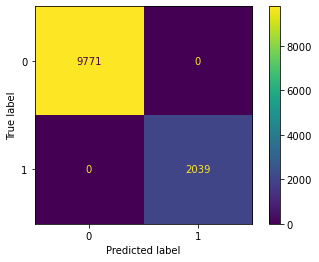

In [41]:
# get confusion matrix and display it
cm = confusion_matrix(y_test, svm_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(values_format="n")

# get tn, fp, fn, tp
tn, fp, fn, tp = cm.flatten()

# calculate accuracy, recall, precision
acc = accuracy_score(np.round(svm_predictions), y_test)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f'Recall:    {recall}')
print(f'Precision: {precision}')
print(f'Accuracy:  {round(acc,4)*100}%')

In [39]:
# delete endpoint
svm_predictor.delete_endpoint()

### Neural Network

In [120]:
!pygmentize ../model/ANN_model.py

from __future__ import print_function

import argparse
import os
import pandas as pd


## Import any additional libraries you need to define a model
from tensorflow import keras
from tensorflow.keras import layers, activations
import tensorflow as tf


if __name__ == '__main__':
        
    # Here we set up an argument parser to easily access the parameters
    parser = argparse.ArgumentParser()

    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--learning-rate', type=float, default=0.001)
    parser.add_argument('--output-data-dir', type=str, default=os.environ['SM_OUTPUT_DATA_DIR'])
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--data-dir', type=str, default=os.environ['SM_CHANNEL_TRAIN'])
    parser.add_argument('--criterion', type=str, default='event_offer completed')
    
    # args holds all passed-in arguments
    args, _ = parser.parse_known_args()

    # Read in csv training file


In [121]:
tf_version = tf.__version__
print(tf_version)

# create tf estimator
tf_estimator = TensorFlow(entry_point='ANN_model.py',
                          source_dir='../model/',
                          role=role,
                          instance_count=1, 
                          instance_type='ml.p2.xlarge',
                          framework_version=tf_version, 
                          py_version='py3',
                          script_mode=True,
                          output_path=output_path,
                          hyperparameters={
                              'epochs': 10
                          }
                         )

1.15.5


In [123]:
# fit ANN. input path is the same as for SVM
tf_estimator.fit({'train': input_path})

2021-09-10 22:04:13 Starting - Starting the training job...
2021-09-10 22:04:36 Starting - Launching requested ML instancesProfilerReport-1631311452: InProgress
......
2021-09-10 22:05:37 Starting - Preparing the instances for training.........
2021-09-10 22:07:01 Downloading - Downloading input data
2021-09-10 22:07:01 Training - Downloading the training image.........
2021-09-10 22:08:37 Training - Training image download completed. Training in progress.WARNING:tensorflow:From /usr/local/lib/python3.6/site-packages/tensorflow_core/__init__.py:1473: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.

2021-09-10 22:08:28,774 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2021-09-10 22:08:29,226 sagemaker-training-toolkit INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "train": "/opt/ml/input/data/train"
    },
    "cur

In [124]:
tf_predictor = tf_estimator.deploy(initial_instance_count = 1, instance_type = 'ml.p2.xlarge')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-------------!

In [125]:
x_test_json = x_test.to_numpy()

In [126]:
tf_predictions = tf_predictor.predict(x_test_json)
# flatten list
tf_predictions_flat = flat_list = [item for sublist in tf_predictions.get('predictions') for item in sublist]
tf_predictions_flat = np.round(tf_predictions_flat)

Recall:    0.0
Precision: nan
Accuracy:  82.73%


/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in long_scalars


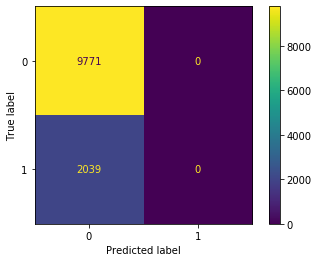

In [127]:
# get confusion matrix and display it
cm = confusion_matrix(y_test, tf_predictions_flat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(values_format="n")

# get tn, fp, fn, tp
tn, fp, fn, tp = cm.flatten()

# calculate accuracy, recall, precision
acc = accuracy_score(tf_predictions_flat, y_test)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f'Recall:    {recall}')
print(f'Precision: {precision}')
print(f'Accuracy:  {round(acc,4)*100}%')

In [128]:
# delete endpoint
tf_predictor.delete_endpoint()

## Comparison of models & Results